### Notebook from : https://www.kaggle.com/code/jiaowoguanren/sars-cov-2-ct-scan-dataset-classification-tf-0-99

In [1]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import pathlib, splitfolders
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


# USE OF SARSCOV2-CTSCAN-DATASET

In [3]:
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

def create_data_binary(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='../sarscov2-ctscan-dataset-splitted/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    train_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/train/', target_size=(img_height, img_width),
                                            class_mode='binary', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/val/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)
    test_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/test/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)
    return train_ds, val_ds, test_ds


train_data, val_data, test_data = create_data_binary('../sarscov2-ctscan-dataset/')

Copying files: 2481 files [00:01, 2070.33 files/s]


Found 1736 images belonging to 2 classes.
Found 371 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


# USE OF COVID-CT-master DATASET

In [ ]:
epochs = 10
batch_size = 32
img_height, img_width = 150, 150
input_shape = (img_height, img_width, 3)

data_gen = ImageDataGenerator(rescale=1.0 / 255)

"""
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
"""
                                  
train_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/train/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          subset='training')
                                         
test_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/test/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary')

val_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/val/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          shuffle=False)

### Base Model CNN

In [8]:
model_base = tf.keras.Sequential(
    [
        Conv2D(32, (3 * 3), padding='same', input_shape = input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),

        Conv2D(32, (3 * 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),
        Dropout(0.3),

        Conv2D(32, (3 * 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

model_base.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Define the callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, save_weights_only=True)

history = model_base.fit(train_data, epochs=20, batch_size=batch_size, validation_data=val_data)
#history = model_base.fit(train_data, epochs=20, validation_data=val_data, batch_size=batch_size, callbacks=[early_stop, checkpoint])

# save model for future use
model_base.save('model_base.h5')

model_base.summary()

Epoch 1/20


2023-03-18 10:11:08.513397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.4899 - accuracy: 0.7540

2023-03-18 10:11:51.357021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 46s 820ms/step - loss: 0.4899 - accuracy: 0.7540 - val_loss: 2.3200 - val_accuracy: 0.5364
Epoch 2/20
55/55 [==============================] - 43s 783ms/step - loss: 0.3463 - accuracy: 0.8485 - val_loss: 7.2867 - val_accuracy: 0.5013
Epoch 3/20
55/55 [==============================] - 44s 804ms/step - loss: 0.2709 - accuracy: 0.8963 - val_loss: 9.9015 - val_accuracy: 0.5040
Epoch 4/20
55/55 [==============================] - 46s 841ms/step - loss: 0.2465 - accuracy: 0.8963 - val_loss: 0.9928 - val_accuracy: 0.7358
Epoch 5/20
55/55 [==============================] - 51s 942ms/step - loss: 0.1968 - accuracy: 0.9205 - val_loss: 2.6121 - val_accuracy: 0.5040
Epoch 6/20
55/55 [==============================] - 54s 979ms/step - loss: 0.1610 - accuracy: 0.9338 - val_loss: 0.7385 - val_accuracy: 0.7871
Epoch 7/20
55/55 [==============================] - 54s 983ms/step - loss: 0.1095 - accuracy: 0.9579 - val_loss: 6.2980 - val_accuracy: 0.6361
Epoch 8/20

In [9]:
test_loss, test_acc = net.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)

12/12 [==============================] - 3s 220ms/step - loss: 0.8670 - accuracy: 0.8422
Test loss: 0.867
Test accuracy: 0.842


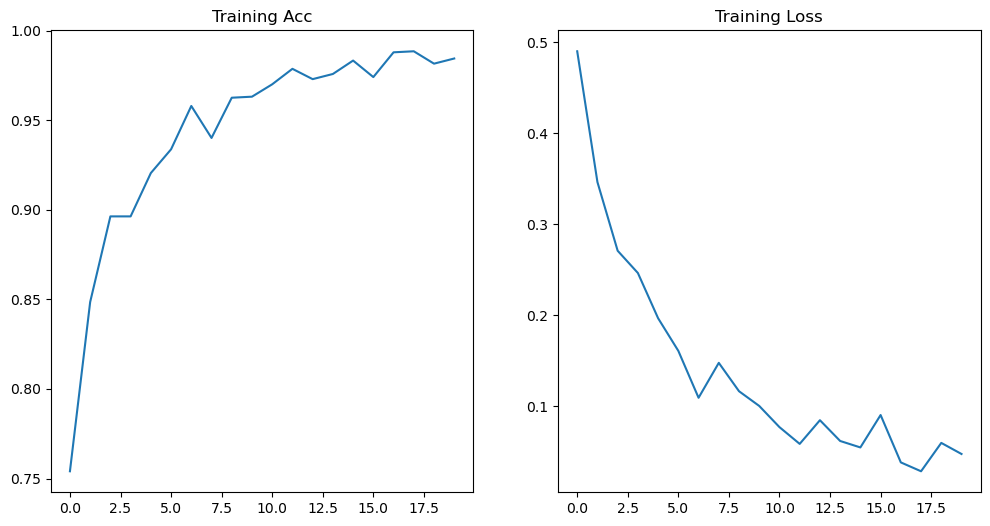

In [10]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

12/12 [==============================] - 3s 225ms/step
[[133  56]
 [  3 182]]


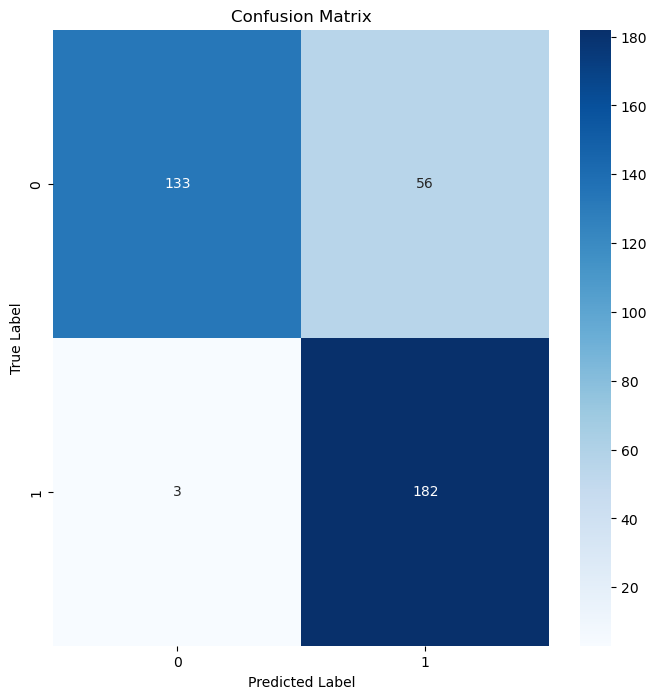

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       189
           1       0.76      0.98      0.86       185

    accuracy                           0.84       374
   macro avg       0.87      0.84      0.84       374
weighted avg       0.87      0.84      0.84       374



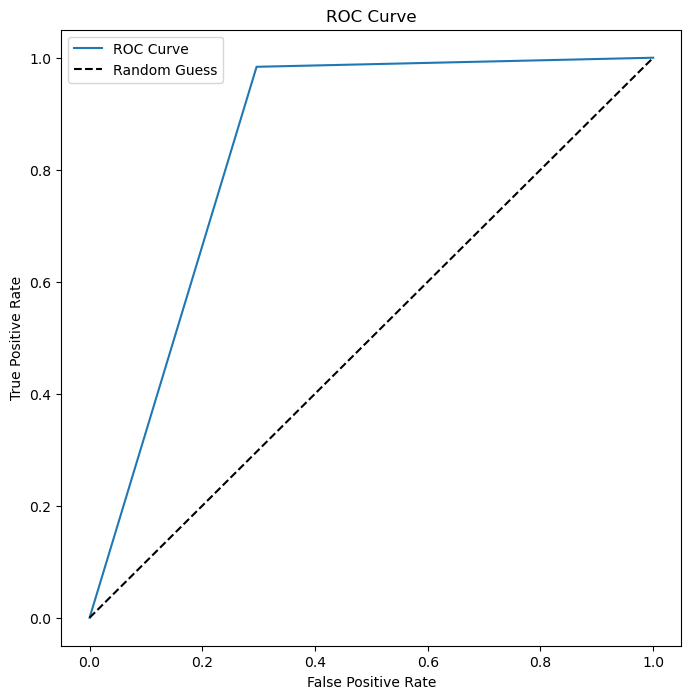

In [14]:
# display the confusion matrix
y_pred = model_base.predict(test_data)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# display the classification report
print(classification_report(test_data.classes, y_pred))

# display the ROC curve
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred)
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### VGG16 CNN

In [15]:
# Load the VGG16 model with pre-trained weights
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the model
for layer in vgg16_model.layers:
    layer.trainable = False

# Add a new classifier on top of the pre-trained model
model_vgg = tf.keras.Sequential([
    vgg16_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and Adam optimizer
model_vgg.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Define the callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, save_weights_only=True)

# Train the model with the training data and validate on the validation data
history = model_vgg.fit(train_data, epochs=10, validation_data=val_data)
#history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stop, checkpoint])

# save model for future use
model_vgg.save('model_vgg.h5')

model_vgg.summary()

Epoch 1/10


2023-03-18 10:31:29.422564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.7529

2023-03-18 10:32:28.051668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 72s 1s/step - loss: 0.5116 - accuracy: 0.7529 - val_loss: 0.2869 - val_accuracy: 0.9003
Epoch 2/10
55/55 [==============================] - 84s 2s/step - loss: 0.2815 - accuracy: 0.8934 - val_loss: 0.1985 - val_accuracy: 0.9434
Epoch 3/10
55/55 [==============================] - 86s 2s/step - loss: 0.1885 - accuracy: 0.9372 - val_loss: 0.1586 - val_accuracy: 0.9542
Epoch 4/10
55/55 [==============================] - 86s 2s/step - loss: 0.1531 - accuracy: 0.9482 - val_loss: 0.1276 - val_accuracy: 0.9704
Epoch 5/10
55/55 [==============================] - 93s 2s/step - loss: 0.1158 - accuracy: 0.9660 - val_loss: 0.1425 - val_accuracy: 0.9434
Epoch 6/10
55/55 [==============================] - 94s 2s/step - loss: 0.0929 - accuracy: 0.9781 - val_loss: 0.0987 - val_accuracy: 0.9757
Epoch 7/10
55/55 [==============================] - 95s 2s/step - loss: 0.0695 - accuracy: 0.9885 - val_loss: 0.0999 - val_accuracy: 0.9730
Epoch 8/10
55/55 [=============

### Accuracy and Loss graphs

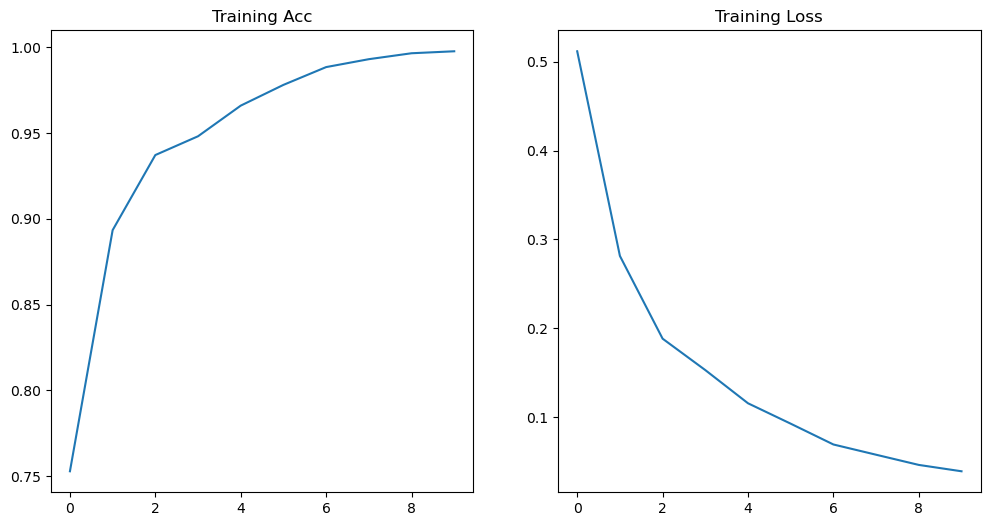

In [16]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

In [17]:
test_loss, test_acc = model_vgg.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)

12/12 [==============================] - 13s 1s/step - loss: 0.0842 - accuracy: 0.9759
Test loss: 0.084
Test accuracy: 0.976


2023-03-18 10:47:08.015872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 13s 1s/step
[[184   5]
 [  4 181]]


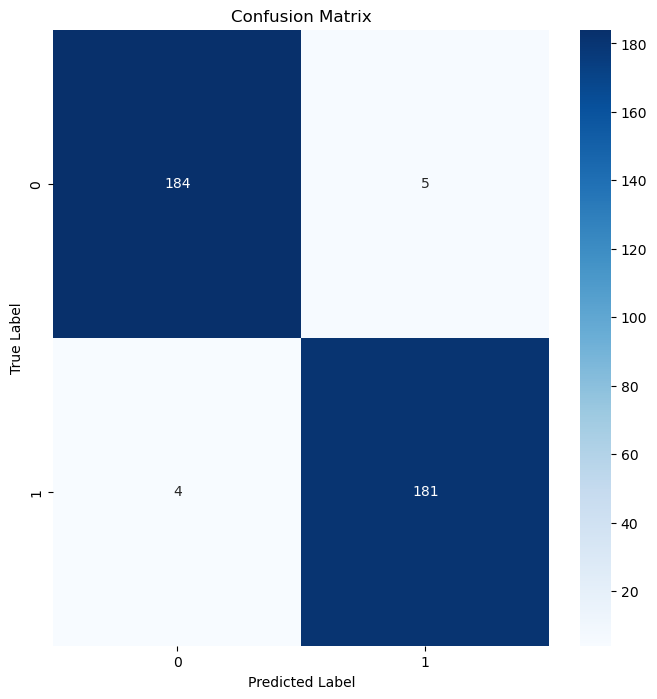

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       189
           1       0.97      0.98      0.98       185

    accuracy                           0.98       374
   macro avg       0.98      0.98      0.98       374
weighted avg       0.98      0.98      0.98       374



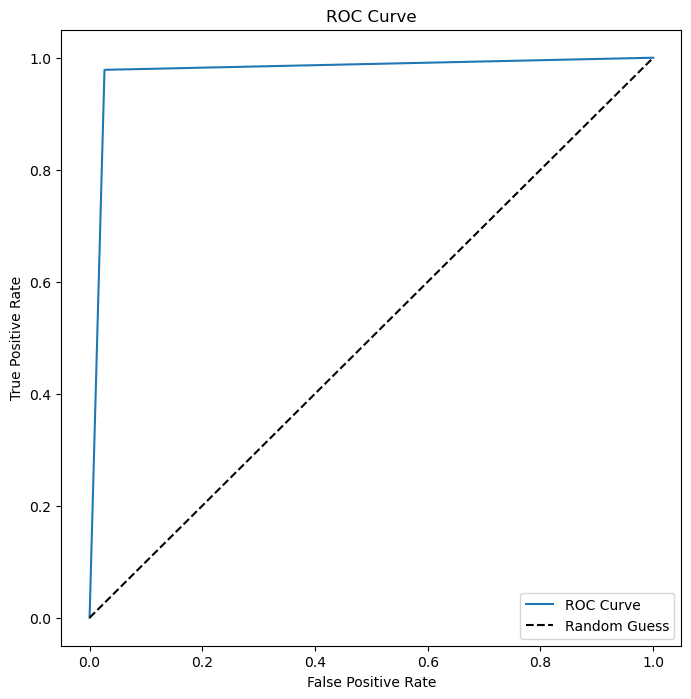

In [18]:
# display the confusion matrix
y_pred = model_vgg.predict(test_data)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# display the classification report
print(classification_report(test_data.classes, y_pred))

# display the ROC curve
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred)
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Cascading CNN

In [20]:
model_cascade = tf.keras.Sequential()

# First CNN block
model_cascade.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cascade.add(MaxPooling2D((2, 2)))
model_cascade.add(Dropout(0.25))

# Second CNN block
model_cascade.add(Conv2D(64, (3, 3), activation='relu'))
model_cascade.add(MaxPooling2D((2, 2)))
model_cascade.add(Dropout(0.25))

# Third CNN block
model_cascade.add(Conv2D(128, (3, 3), activation='relu'))
model_cascade.add(MaxPooling2D((2, 2)))
model_cascade.add(Dropout(0.25))

# Flatten layer
model_cascade.add(Flatten())

# Dense layers
model_cascade.add(Dense(64, activation='relu'))
model_cascade.add(Dropout(0.5))
model_cascade.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cascade.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the data
model_cascade.fit(train_data, epochs=20, validation_data=val_data)

# save model for future use
model_cascade.save('model_cascade.h5')

model_cascade.summary()

Epoch 1/20


2023-03-18 10:48:09.655952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 1.1246 - accuracy: 0.5115

2023-03-18 10:48:32.489809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 25s 436ms/step - loss: 1.1246 - accuracy: 0.5115 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/20
55/55 [==============================] - 24s 431ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/20
55/55 [==============================] - 24s 438ms/step - loss: 0.6935 - accuracy: 0.5017 - val_loss: 0.6930 - val_accuracy: 0.5040
Epoch 4/20
55/55 [==============================] - 23s 427ms/step - loss: 0.6914 - accuracy: 0.5334 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 5/20
55/55 [==============================] - 24s 430ms/step - loss: 0.6553 - accuracy: 0.6094 - val_loss: 0.6116 - val_accuracy: 0.7978
Epoch 6/20
55/55 [==============================] - 24s 440ms/step - loss: 0.5879 - accuracy: 0.7022 - val_loss: 0.5487 - val_accuracy: 0.8140
Epoch 7/20
55/55 [==============================] - 24s 435ms/step - loss: 0.5195 - accuracy: 0.7442 - val_loss: 0.4535 - val_accuracy: 0.8275
Epoch 8/20

In [21]:
test_loss, test_acc = model_cascade.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)

12/12 [==============================] - 2s 157ms/step - loss: 0.2596 - accuracy: 0.9144
Test loss: 0.260
Test accuracy: 0.914


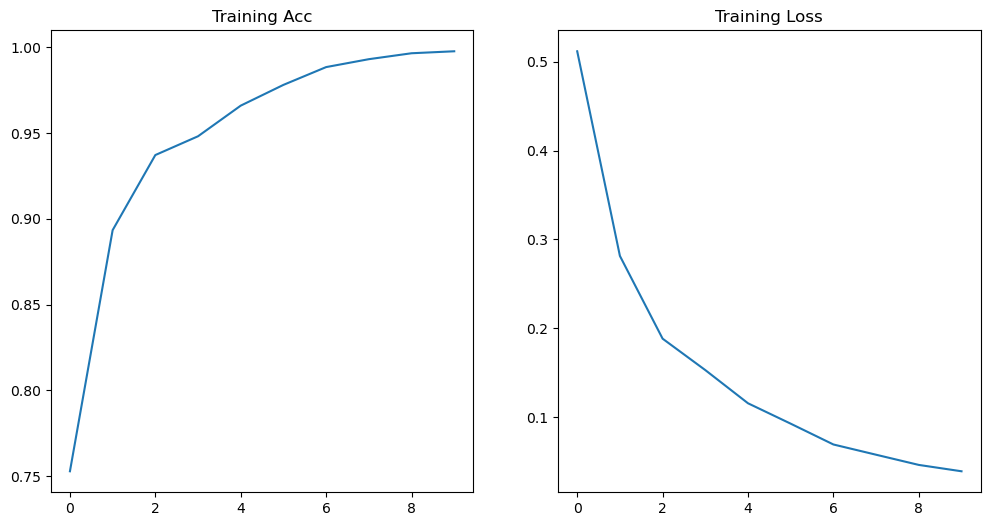

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

 1/12 [=>............................] - ETA: 2s

2023-03-18 10:56:33.983845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 151ms/step
[[183   6]
 [ 26 159]]


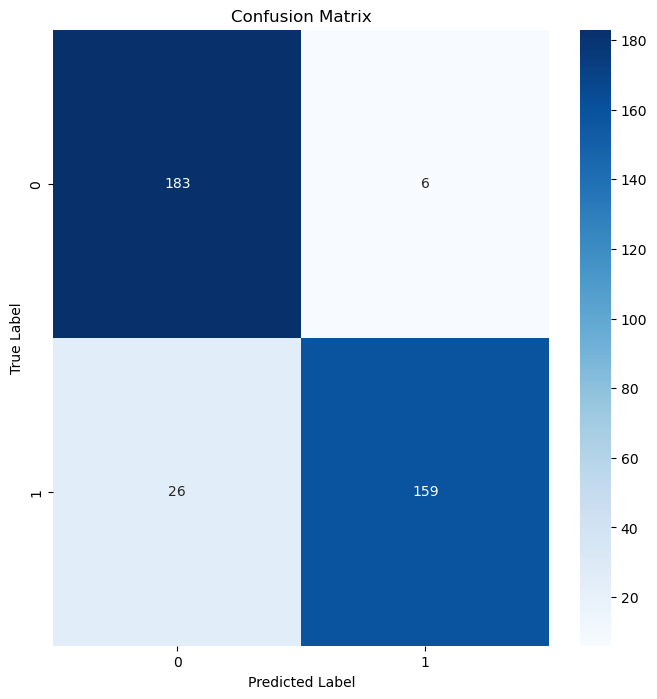

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       189
           1       0.96      0.86      0.91       185

    accuracy                           0.91       374
   macro avg       0.92      0.91      0.91       374
weighted avg       0.92      0.91      0.91       374



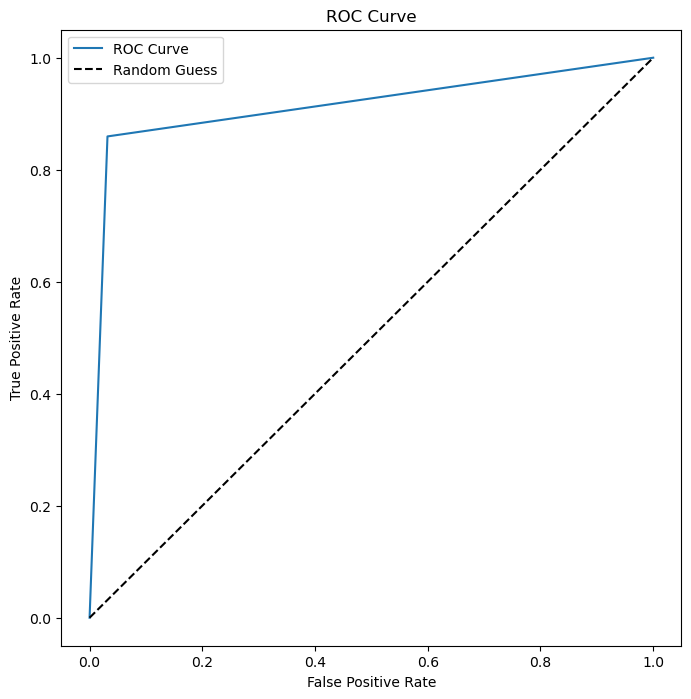

In [23]:
# display the confusion matrix
y_pred = model_cascade.predict(test_data)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# display the classification report
print(classification_report(test_data.classes, y_pred))

# display the ROC curve
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred)
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()